Load Julia packages (libraries) needed  for the snippets in chapter 0

In [1]:
using StatisticalRethinking, CmdStan, StanMCMCChain, LinearAlgebra
gr(size=(500,500));

CmdStan uses a tmp directory to store the output of cmdstan

In [2]:
ProjDir = rel_path("..", "scripts", "04")
cd(ProjDir)

### snippet 4.7

In [3]:
howell1 = CSV.read(rel_path("..", "data", "Howell1.csv"), delim=';')
df = convert(DataFrame, howell1);

Use only adults

In [4]:
df2 = filter(row -> row[:age] >= 18, df);

Separate male and fermale observations

In [5]:
female_df = filter(row -> row[:male] == 0, df2);
male_df = filter(row -> row[:male] == 1, df2);
first(male_df, 5)

,height,weight,age,male
,Float64⍰,Float64⍰,Float64⍰,Int64⍰
1,151.765,47.8256,63.0,1
2,156.845,53.0419,41.0,1
3,163.83,62.9926,35.0,1
4,168.91,55.48,27.0,1
5,165.1,54.4877,54.0,1


Plot the densities.

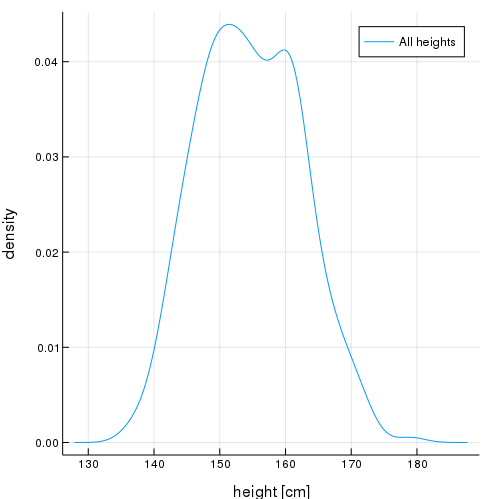

In [6]:
density(df2[:height], lab="All heights", xlab="height [cm]", ylab="density")

Is it bi-modal?

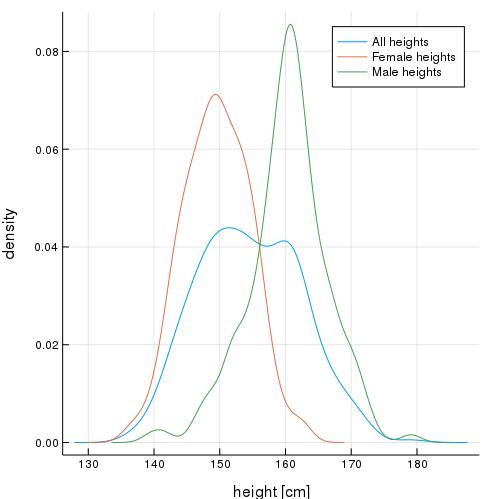

In [7]:
density!(female_df[:height], lab="Female heights")
density!(male_df[:height], lab="Male heights")

Define the Stan language model

In [8]:
heightsmodel = "
// Inferring a Rate
data {
  int N;
  real<lower=0> h[N];
}
parameters {
  real<lower=0> sigma;
  real<lower=0,upper=250> mu;
}
model {
  // Priors for mu and sigma
  mu ~ normal(178, 20);
  sigma ~ uniform( 0 , 50 );

  // Observed heights
  h ~ normal(mu, sigma);
}
";

Define the Stanmodel and set the output format to :mcmcchain.

In [9]:
stanmodel = Stanmodel(name="heights", monitors = ["mu", "sigma"],model=heightsmodel,
  output_format=:mcmcchain);
# Input data for cmdstan
heightsdata = Dict("N" => length(df2[:height]), "h" => df2[:height]);

Sample using cmdstan

In [10]:
rc, chn, cnames = stan(stanmodel, heightsdata, ProjDir, diagnostics=false,
  summary=false, CmdStanDir=CMDSTAN_HOME);
# Describe the draws
describe(chn)

Iterations = 1:1000
Thinning interval = 1
Chains = 1,2,3,4
Samples per chain = 1000

Empirical Posterior Estimates:
         Mean        SD       Naive SE       MCSE      ESS
sigma   7.772146 0.29369297 0.0046436936 0.0041242773 1000
   mu 154.589084 0.41501097 0.0065618996 0.0080493871 1000

Quantiles:
         2.5%      25.0%     50.0%     75.0%       97.5%  
sigma   7.226044   7.56999   7.7633   7.9628625   8.362019
   mu 153.779000 154.30650 154.5925 154.8782500 155.386000



Plot the density of posterior draws

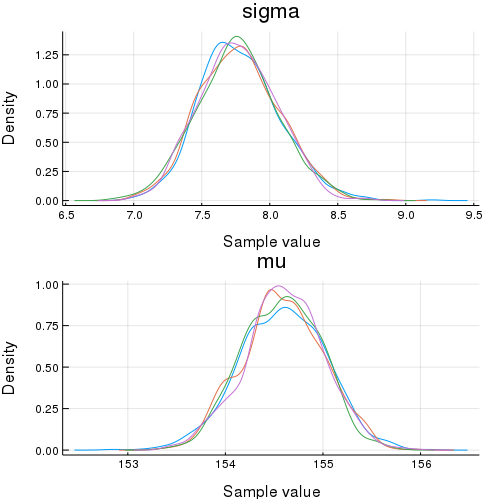

In [11]:
density(chn, lab="All heights", xlab="height [cm]", ylab="density")

Compute cor

In [12]:
mu_sigma = hcat(chn.value[:, 2, 1], chn.value[:,1, 1])
LinearAlgebra.diag(cov(mu_sigma))

2-element Array{Float64,1}:
 0.1954739929369366 
 0.08681477971908697

Compute cov

In [13]:
cor(mu_sigma)

2×2 Array{Float64,2}:
 1.0        0.0367383
 0.0367383  1.0      

End of `clip_07.0s.jl`

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*